In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

from custom_callbacks import MultiAccuracyBestPerformanceCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Isolate meaningful data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

unique_roots = sorted(list(set([harmoutil.split_root_suffix(ch)[0] for ch in chords])))
unique_suffixes = sorted(list(set([harmoutil.split_root_suffix(ch)[1] for ch in chords])))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
unique_notes = sorted(list(set(notes)))

print("Unique notes ({}): {}".format(len(unique_notes), unique_notes))
print("Unique chords ({}): {}".format(len(unique_chords), unique_chords))
print("Unique roots ({}): {}".format(len(unique_roots), unique_roots))
print("Unique suffixes ({}): {}".format(len(unique_suffixes), unique_suffixes))

Unique notes (13): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique chords (193): ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', 'Dsus', 'Dsus7', 'E', 'E+', 'E+7', 'E+j7', 'E-', 'E-6', 'E-7', 'E-j7', 'E6', 'E7', 'Eb', 'Eb+', 'Eb+7

In [4]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

root_to_int = dict([(c, i) for i, c in enumerate(unique_roots)])
root_to_int['<bos>'] = len(root_to_int)

int_to_root = dict([(k, v) for v, k in root_to_int.items()])

suffix_to_int = dict([(c, i) for i, c in enumerate(unique_suffixes)])
suffix_to_int['<bos>'] = len(suffix_to_int)

int_to_suffix = dict([(k, v) for v, k in suffix_to_int.items()])


print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))
print("Root labels to integer mapping:\n {}\n".format(root_to_int))
print("Integer to root label mapping:\n {}\n".format(int_to_root))
print("Suffix label to integer mapping:\n {}\n".format(suffix_to_int))
print("Integer to suffix label mapping:\n {}\n".format(int_to_suffix))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Absus7': 25, 'Gb+': 171, 'Abj7': 20, 'Dbm7b5': 101, 'B-6': 37, 'G+': 161, 'F-j7': 151, 'Dj7': 106, 'Eo': 140, 'B6': 40, 'Bsus7': 63, 'A+7': 2, 'Dbo7': 103, 'Cm7b5': 75, 'F6': 152, 'Gbo': 182, 'C-6': 69, 'Esus': 142, 'Csus': 78, 'Bsus': 62, 'Asus7': 31, 'G+7': 162, 'Am7b5': 27, 'C': 64, 'Gm7b5': 187, 'Bbj7': 52, 'E+7': 114, 'D-': 84, 'Bb+j7': 45, 'Eb6': 130, 'Db-6': 95, 'Dbj7': 100, 'Ab7': 19, 'Bbsus': 56, 'B7': 41, 'Eb-j7': 129, 'Em7b5': 139, 'A-6': 5, 'D7': 89, 'Bb-j7': 49, 'Esus7': 143, 'Ebj7': 132, 'Bb+': 43, 'Gbsus7': 185, 'Eb': 122, 'Fsus7': 159, 'Bo': 60, 'E-7': 118, 'Ab-': 14, 'Db-j7': 97, 'Eb+': 123, 'C-': 68, 'C7': 73, 'Bb7': 51, 'Dm7b5': 107, 'Gb-7': 176, 'Fo': 156, 'Gsus7': 191, 'A

In [5]:
# Refine data that will actually be used
def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False

def check_if_NC(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "NC" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
section_data = [section for section in data if not check_if_augmented_major(section)]
print("Number of sections: {}\n".format(len(section_data)))

# Remove sections that involve NC (no chord)
section_data = [section for section in section_data if not check_if_NC(section)]
print("Number of sections: {}\n".format(len(section_data)))

chords_by_sections = [get_chords_by_section(section) for section in section_data]
chords_data = [chord_info[0] for section in section_data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in section_data for chord_info in section]

Number of sections: 28836

Number of sections: 28416



In [6]:
# Define numerical variables

n_samples = len(chords_data)
n_chords = len(chord_to_int)
n_roots = len(root_to_int)
n_suffixes = len(suffix_to_int)
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of distinct root labels", n_roots)
print("Number of distinct suffix labels:", n_suffixes)
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 327708
Number of distinct melody notes: 14
Number of distinct chord labels: 194
Number of distinct root labels 14
Number of distinct suffix labels: 17
Maximum length of melody sequences for one chord: 115
Number of past chords given as input: 7


In [7]:
# Prepare tensor data
def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_root_sequence = context_len*['<bos>'] + [harmoutil.split_root_suffix(ch)[0] for ch in chord_seq]
    padded_suffix_sequence = context_len*['<bos>'] + [harmoutil.split_root_suffix(ch)[1] for ch in chord_seq]
    padded_chord_sequence = context_len*['<bos>'] + chord_seq
    formatted_root_sequences = [padded_root_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    formatted_suffix_sequences = [padded_suffix_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    formatted_chord_sequences = [padded_chord_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_chord_sequences, formatted_root_sequences, formatted_suffix_sequences


# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
formatted_roots_data = []
formatted_suffixes_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)[0]
    formatted_roots_data += build_input_chord_sequences(section_chords, chord_context_len)[1]
    formatted_suffixes_data += build_input_chord_sequences(section_chords, chord_context_len)[2]

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
input_roots_data = [ch[:-1] for ch in formatted_roots_data]
input_suffixes_data = [ch[:-1] for ch in formatted_suffixes_data]

target_chords_data = [ch[-1] for ch in formatted_chords_data] 
target_roots_data = [ch[-1] for ch in formatted_roots_data]
target_suffixes_data = [ch[-1] for ch in formatted_suffixes_data]

print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))
print("Sample input root sequence: {}\n".format(input_roots_data[5]))
print("Sample input suffix sequence: {}\n".format(input_suffixes_data[5]))
print("Sample target root: {}\n".format(target_roots_data[5]))
print("Sample target suffix: {}\n".format(target_suffixes_data[5]))


print("Input melody: {}, Input roots & suffixes: {} {}, Target roots & suffixes: {} {}".format(len(input_melody_data), len(input_roots_data), len(input_suffixes_data), len(target_roots_data), len(target_suffixes_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_roots = np.zeros((n_samples, chord_context_len, n_roots), dtype='float32')
X_suffixes = np.zeros((n_samples, chord_context_len, n_suffixes), dtype='float32')
Y_roots = np.zeros((n_samples, n_roots), dtype='float32')
Y_suffixes = np.zeros((n_samples, n_suffixes), dtype='float32')

X_labels = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')


for i, (input_mel, input_ch, input_rt, input_sf, target_ch, target_rt, target_sf) in enumerate(zip(input_melody_data, input_chords_data, input_roots_data, input_suffixes_data, target_chords_data, target_roots_data, target_suffixes_data)):
    Y_labels[i, chord_to_int[target_ch]] = 1
    Y_roots[i, root_to_int[target_rt]] = 1
    Y_suffixes[i, suffix_to_int[target_sf]] = 1
    
    for j, (chord, root, suffix) in enumerate(zip(input_ch, input_rt, input_sf)):
        X_labels[i, j, chord_to_int[chord]] = 1
        X_roots[i, j, root_to_int[root]] = 1
        X_suffixes[i, j, suffix_to_int[suffix]] = 1
    
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1

In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_labels, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    
    X_labels_train, X_labels_aux = X_labels[train_index], X_labels[aux_index]
    X_roots_train, X_roots_aux = X_roots[train_index], X_roots[aux_index]
    X_suffixes_train, X_suffixes_aux = X_suffixes[train_index], X_suffixes[aux_index]
    
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    Y_roots_train, Y_roots_aux = Y_roots[train_index], Y_roots[aux_index]
    Y_suffixes_train, Y_suffixes_aux = Y_suffixes[train_index], Y_suffixes[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_labels_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody_aux[valid_index], X_melody_aux[test_index]
    
    X_labels_valid, X_labels_test = X_labels_aux[valid_index], X_labels_aux[test_index]
    X_roots_valid, X_roots_test = X_roots_aux[valid_index], X_roots_aux[test_index]
    X_suffixes_valid, X_suffixes_test = X_suffixes_aux[valid_index], X_suffixes_aux[test_index]
    
    Y_labels_valid, Y_labels_test = Y_labels_aux[valid_index], Y_labels_aux[test_index]
    Y_roots_valid, Y_roots_test = Y_roots_aux[valid_index], Y_roots_aux[test_index]
    Y_suffixes_valid, Y_suffixes_test = Y_suffixes_aux[valid_index], Y_suffixes_aux[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

roots_input = Input(shape=(chord_context_len, n_roots))
roots_gru1 = GRU(latent_dim, return_sequences=True)(roots_input)
roots_gru2 = GRU(latent_dim, return_sequences=True)(roots_gru1)
roots_gru3 = GRU(latent_dim)(roots_gru2)

suffixes_input = Input(shape=(chord_context_len, n_suffixes))
suffixes_gru1 = GRU(latent_dim, return_sequences=True)(suffixes_input)
suffixes_gru2 = GRU(latent_dim, return_sequences=True)(suffixes_gru1)
suffixes_gru3 = GRU(latent_dim)(suffixes_gru2)

concat = concatenate([melody_gru3, roots_gru3, suffixes_gru3])

root_hidden1 = Dense(latent_dim, activation='relu')(concat)
root_hidden2 = Dense(latent_dim, activation='relu')(root_hidden1)
root_dense = Dense(n_roots, activation='softmax', name="root_predict")(root_hidden2)

suffix_hidden1 = Dense(latent_dim, activation='relu')(concat)
suffix_hidden2 = Dense(latent_dim, activation='relu')(suffix_hidden1)
suffix_dense = Dense(n_suffixes, activation='softmax', name="suffix_predict")(suffix_hidden2)

model = Model([melody_input, roots_input, suffixes_input], [root_dense, suffix_dense])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 115, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 14)         0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 7, 17)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 115, 128)      54912       input_1[0][0]                    
___________________________________________________________________________________________

In [11]:
# Introduce Save-Best-Performance callbacks
filepath = "RootSuffix_depth3.h5"
# bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
mabpc = MultiAccuracyBestPerformanceCheckpoint(filepath, monitor=['val_root_predict_acc', 'val_suffix_predict_acc'], verbose=1)

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_roots_train, X_suffixes_train], [Y_roots_train, Y_suffixes_train], epochs=epochs, validation_data=([X_melody_valid, X_roots_valid, X_suffixes_valid], [Y_roots_valid, Y_suffixes_valid]), batch_size=batch_size, callbacks=[mabpc])

Train on 262166 samples, validate on 32771 samples
Epoch 1/150
262144/262166 [============================>.] - ETA: 0s - loss: 2.8496 - root_predict_loss: 1.6449 - suffix_predict_loss: 1.2048 - root_predict_acc: 0.4812 - suffix_predict_acc: 0.5829
Epoch 00001: ['val_root_predict_acc', 'val_suffix_predict_acc'] improved from [0.0, 0.0] => -inf to [0.56873455189220967, 0.67709255134112478] => 1.24583, saving model to RootSuffix_depth3.h5
262166/262166 [==============================] - 469s - loss: 2.8496 - root_predict_loss: 1.6449 - suffix_predict_loss: 1.2048 - root_predict_acc: 0.4812 - suffix_predict_acc: 0.5829 - val_loss: 2.2845 - val_root_predict_loss: 1.3700 - val_suffix_predict_loss: 0.9145 - val_root_predict_acc: 0.5687 - val_suffix_predict_acc: 0.6771
Epoch 2/150
262144/262166 [============================>.] - ETA: 0s - loss: 1.9698 - root_predict_loss: 1.2164 - suffix_predict_loss: 0.7534 - root_predict_acc: 0.6151 - suffix_predict_acc: 0.7343
Epoch 00002: ['val_root_predi

262166/262166 [==============================] - 463s - loss: 0.7519 - root_predict_loss: 0.4550 - suffix_predict_loss: 0.2969 - root_predict_acc: 0.8395 - suffix_predict_acc: 0.8851 - val_loss: 0.8777 - val_root_predict_loss: 0.5552 - val_suffix_predict_loss: 0.3225 - val_root_predict_acc: 0.8178 - val_suffix_predict_acc: 0.8793
Epoch 23/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.7222 - root_predict_loss: 0.4411 - suffix_predict_loss: 0.2811 - root_predict_acc: 0.8443 - suffix_predict_acc: 0.8907
Epoch 00023: ['val_root_predict_acc', 'val_suffix_predict_acc'] improved from [0.81782673705410269, 0.87928351286198159] => 1.69711 to [0.81883372493973328, 0.88199932867474296] => 1.70083, saving model to RootSuffix_depth3.h5
262166/262166 [==============================] - 463s - loss: 0.7221 - root_predict_loss: 0.4411 - suffix_predict_loss: 0.2810 - root_predict_acc: 0.8443 - suffix_predict_acc: 0.8907 - val_loss: 0.8610 - val_root_predict_loss: 0.5493 - val_su

262166/262166 [==============================] - 461s - loss: 0.5556 - root_predict_loss: 0.3502 - suffix_predict_loss: 0.2053 - root_predict_acc: 0.8759 - suffix_predict_acc: 0.9211 - val_loss: 0.8040 - val_root_predict_loss: 0.5393 - val_suffix_predict_loss: 0.2647 - val_root_predict_acc: 0.8385 - val_suffix_predict_acc: 0.9037
Epoch 34/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.5365 - root_predict_loss: 0.3401 - suffix_predict_loss: 0.1964 - root_predict_acc: 0.8803 - suffix_predict_acc: 0.9240
Epoch 00034: ['val_root_predict_acc', 'val_suffix_predict_acc'] did not improve from 1.74221
262166/262166 [==============================] - 459s - loss: 0.5365 - root_predict_loss: 0.3401 - suffix_predict_loss: 0.1964 - root_predict_acc: 0.8803 - suffix_predict_acc: 0.9240 - val_loss: 0.8037 - val_root_predict_loss: 0.5376 - val_suffix_predict_loss: 0.2661 - val_root_predict_acc: 0.8383 - val_suffix_predict_acc: 0.9035
Epoch 35/150
262144/262166 [================

262144/262166 [============================>.] - ETA: 0s - loss: 0.3617 - root_predict_loss: 0.2355 - suffix_predict_loss: 0.1262 - root_predict_acc: 0.9186 - suffix_predict_acc: 0.9527
Epoch 00057: ['val_root_predict_acc', 'val_suffix_predict_acc'] improved from [0.85712977937810875, 0.91916633608983556] => 1.77630 to [0.85902169601171763, 0.92377406853620581] => 1.78280, saving model to RootSuffix_depth3.h5
262166/262166 [==============================] - 457s - loss: 0.3617 - root_predict_loss: 0.2355 - suffix_predict_loss: 0.1262 - root_predict_acc: 0.9186 - suffix_predict_acc: 0.9527 - val_loss: 0.8222 - val_root_predict_loss: 0.5698 - val_suffix_predict_loss: 0.2524 - val_root_predict_acc: 0.8590 - val_suffix_predict_acc: 0.9238
Epoch 58/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.3566 - root_predict_loss: 0.2327 - suffix_predict_loss: 0.1239 - root_predict_acc: 0.9201 - suffix_predict_acc: 0.9537
Epoch 00058: ['val_root_predict_acc', 'val_suffix_predic

262166/262166 [==============================] - 457s - loss: 0.5670 - root_predict_loss: 0.3415 - suffix_predict_loss: 0.2255 - root_predict_acc: 0.8802 - suffix_predict_acc: 0.9136 - val_loss: 0.8089 - val_root_predict_loss: 0.5306 - val_suffix_predict_loss: 0.2783 - val_root_predict_acc: 0.8454 - val_suffix_predict_acc: 0.8973
Epoch 83/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.5328 - root_predict_loss: 0.3229 - suffix_predict_loss: 0.2099 - root_predict_acc: 0.8862 - suffix_predict_acc: 0.9196
Epoch 00083: ['val_root_predict_acc', 'val_suffix_predict_acc'] did not improve from 1.78978
262166/262166 [==============================] - 457s - loss: 0.5329 - root_predict_loss: 0.3229 - suffix_predict_loss: 0.2099 - root_predict_acc: 0.8862 - suffix_predict_acc: 0.9196 - val_loss: 0.8353 - val_root_predict_loss: 0.5496 - val_suffix_predict_loss: 0.2858 - val_root_predict_acc: 0.8439 - val_suffix_predict_acc: 0.8969
Epoch 84/150
262144/262166 [================

262166/262166 [==============================] - 458s - loss: 0.4321 - root_predict_loss: 0.2678 - suffix_predict_loss: 0.1644 - root_predict_acc: 0.9094 - suffix_predict_acc: 0.9391 - val_loss: 0.8762 - val_root_predict_loss: 0.5879 - val_suffix_predict_loss: 0.2883 - val_root_predict_acc: 0.8506 - val_suffix_predict_acc: 0.9076
Epoch 109/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.4561 - root_predict_loss: 0.2818 - suffix_predict_loss: 0.1744 - root_predict_acc: 0.9037 - suffix_predict_acc: 0.9346
Epoch 00109: ['val_root_predict_acc', 'val_suffix_predict_acc'] did not improve from 1.78978
262166/262166 [==============================] - 459s - loss: 0.4561 - root_predict_loss: 0.2818 - suffix_predict_loss: 0.1744 - root_predict_acc: 0.9037 - suffix_predict_acc: 0.9346 - val_loss: 0.8487 - val_root_predict_loss: 0.5784 - val_suffix_predict_loss: 0.2703 - val_root_predict_acc: 0.8544 - val_suffix_predict_acc: 0.9116
Epoch 110/150
262144/262166 [==============

262166/262166 [==============================] - 458s - loss: 0.4577 - root_predict_loss: 0.2813 - suffix_predict_loss: 0.1764 - root_predict_acc: 0.9050 - suffix_predict_acc: 0.9338 - val_loss: 0.8657 - val_root_predict_loss: 0.5784 - val_suffix_predict_loss: 0.2873 - val_root_predict_acc: 0.8517 - val_suffix_predict_acc: 0.9055
Epoch 135/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.4238 - root_predict_loss: 0.2621 - suffix_predict_loss: 0.1617 - root_predict_acc: 0.9116 - suffix_predict_acc: 0.9394
Epoch 00135: ['val_root_predict_acc', 'val_suffix_predict_acc'] did not improve from 1.78978
262166/262166 [==============================] - 457s - loss: 0.4239 - root_predict_loss: 0.2621 - suffix_predict_loss: 0.1617 - root_predict_acc: 0.9116 - suffix_predict_acc: 0.9393 - val_loss: 0.8510 - val_root_predict_loss: 0.5831 - val_suffix_predict_loss: 0.2679 - val_root_predict_acc: 0.8556 - val_suffix_predict_acc: 0.9102
Epoch 136/150
262144/262166 [==============

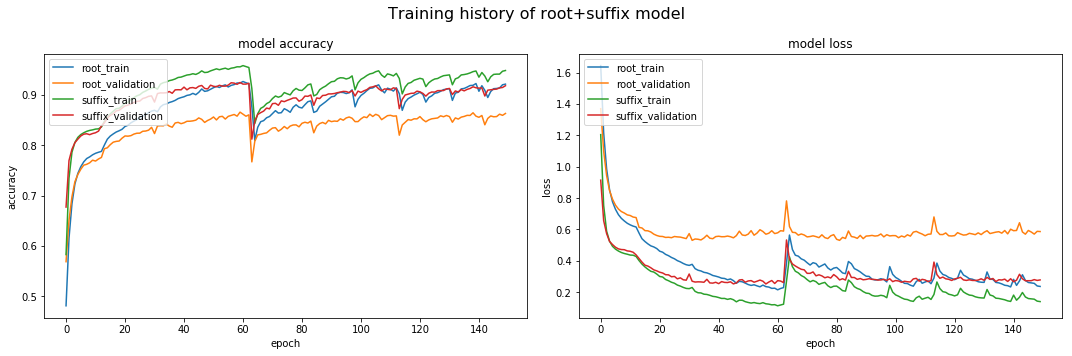

In [13]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['root_predict_acc'])
plt.plot(history.history['val_root_predict_acc'])
plt.plot(history.history['suffix_predict_acc'])
plt.plot(history.history['val_suffix_predict_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_predict_loss'])
plt.plot(history.history['val_root_predict_loss'])
plt.plot(history.history['suffix_predict_loss'])
plt.plot(history.history['val_suffix_predict_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root+suffix model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Load best performance model
best_model = load_model("RootSuffix_depth3.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_roots_pred, Y_suffixes_pred = best_model.predict([X_melody_test, X_roots_test, X_suffixes_test])

# Compute accuracy and kappa score for root
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, Y_roots_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, Y_roots_pred)))

# Compute accuracy and kappa score for suffix
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_suffixes_test, Y_suffixes_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_suffixes_test, Y_suffixes_pred)))

Categorical accuracy of combined chord label prediction: 0.8638
Kappa score of combined chord label prediction: 0.8514
Categorical accuracy of combined chord label prediction: 0.9241
Kappa score of combined chord label prediction: 0.8936


In [16]:
# Evaluate prediction in terms of pitches
def root_suffix_to_pitch_tensors(rt_preds, sf_preds):
    predicted_roots = [int_to_root[np.argmax(rt)] for rt in rt_preds]
    predicted_suffixes = [int_to_suffix[np.argmax(sf)] for sf in sf_preds]
    predicted_chords = [rt+sf for (rt, sf) in zip(predicted_roots, predicted_suffixes)]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((rt_preds.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_rootsuffix_pred_pitch = root_suffix_to_pitch_tensors(Y_roots_pred, Y_suffixes_pred)
Y_rootsuffix_test_pitch = root_suffix_to_pitch_tensors(Y_roots_test, Y_suffixes_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_rootsuffix_test_pitch, Y_rootsuffix_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_rootsuffix_test_pitch, Y_rootsuffix_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9337
TP: 115316 TN: 251847 FP: 13045 FN: 13044
Kappa score of combined chord pitch prediction: 0.8491
